# Initialization

## Packages

In [1]:
import datetime, os
import numpy as np
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(7)

In [2]:
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATA_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Data')
MODEL_DIR = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models')
SAVED_MODEL = os.path.join(MOUNTPOINT, 'MyDrive/Membership_Inference/Models_trained')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


In [3]:
%load_ext tensorboard
log_dir=os.path.join(MODEL_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Pipeline

In [4]:
def windowed_dataset(series, window_size):
  """Chunks the series to small windows of size:window_size
  and shuffles the dataset"""
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=None, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  return dataset

In [5]:
def sequence_preprocessing(data, Id_column,x_column, y_column, window_size):
  """Groups vessels by ID and uses sliding windows to create the dataset
  From shape: (N_samples, features)
  to shape: (N_entries(=Number of windows), window_size, features)"""
  
  #Groups data by ID
  vessels = data.groupby(Id_column)

  for key, group in vessels:
    if(int(group.shape[0]) <= window_size):
      data.drop(data[data[Id_column] == key].index, inplace=True)
  vessels = data.groupby(Id_column)

  vessels_list = []

  #Split each vessel's trajectory into windows
  for _,vessel in vessels:
    vessel_temp = vessel.to_numpy()[:,x_column:y_column].astype('float64')
    windowed_vessel = windowed_dataset(vessel_temp, window_size)
    vessels_list.append(windowed_vessel)

  #Concat
  vessels_list = [[window for window in vessel] for vessel in vessels_list]
  vessels_window = tf.concat(vessels_list, axis=0)

  return vessels_window

# Data

In [6]:
TRAIN_DIR = 'AIS_2018_04_17.csv'
TEST_DIR = 'AIS_2018_12_18.csv'

window_size = 25
n_in = window_size

id_column = "MMSI"
first_column = 1
last_column = 9

## Train

In [7]:
train_path=os.path.join(DATA_DIR, TRAIN_DIR)
train_data = pd.read_csv(train_path, delimiter=",")
train_data.drop(['BaseDateTime', 'VesselName', 'IMO', 'CallSign', 'Status', 'Draft', 'Cargo', 'TransceiverClass'], axis=1, inplace=True)
train_data.dropna(subset = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'Length', 'Width'], inplace=True)
train_data = train_data[['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'VesselType']]
train_data.head()

,MMSI,LAT,LON,SOG,COG,Heading,Length,Width,VesselType
0,367384840,34.40805,-119.69151,0.0,0.0,511.0,19.0,6.0,60.0
1,367384840,34.40804,-119.69150,0.0,0.0,511.0,19.0,6.0,60.0
2,367384840,34.40805,-119.69149,0.0,0.0,511.0,19.0,6.0,60.0
3,367384840,34.40805,-119.69152,0.0,57.7,511.0,19.0,6.0,60.0
4,367384840,34.40805,-119.69151,0.0,0.0,511.0,19.0,6.0,60.0


In [8]:
print("types of ships: ", train_data["VesselType"].unique())
print("\nNumber of ships in the dataset are :", len(train_data["MMSI"].unique()))
train_ships = train_data["MMSI"].unique()
print("\nShape :", train_data.shape)

types of ships:  [60. 31.  0. 90. 80. 30. 52. 70. 51. 37. 50. 39. 36. 20. 69. 79. 33. 49.
 68. 97. 47. 99. 74.  9. 32. 54. 38. 53. 57. 71. 25. 34. 55. 29. 75. 67.
 16. 83. 92. 91. 82. 59. 89. 35. 73. 56. 10.]

Number of ships in the dataset are : 9740

Shape : (5414118, 9)


In [9]:
train_data = train_data.head(1500000)

In [10]:
train_data = train_data[train_data.VesselType != 0]
train_data.VesselType.replace({30.0: 0, 31.0: 1, 36.0: 2, 37.0: 3, 
                               50.0: 4, 52.0: 5, 60.0: 6, 70.0: 7,
                               80.0: 8, 90.0: 9}, inplace=True)
train_data.drop(train_data[train_data.VesselType > 9].index, inplace=True)
train_data.VesselType.value_counts()

1.0    845233
3.0    144987
0.0    139102
9.0    112535
6.0     92388
7.0     55164
8.0     42091
5.0     25300
4.0     10406
2.0      9373
Name: VesselType, dtype: int64

In [11]:
tf_train_data = sequence_preprocessing(train_data, id_column, first_column, last_column, window_size)

In [12]:
train = tf_train_data
X_train = train[:, :, 0:7]
y_train = train[:, :, 7]
y_train = y_train[:, 1]

print(X_train.shape)
print(y_train.shape)

(58036, 25, 7)
(58036,)


## Test

In [13]:
test_path=os.path.join(DATA_DIR, TEST_DIR)
test_data = pd.read_csv(test_path, delimiter=",")
test_data.drop(['BaseDateTime', 'VesselName', 'IMO', 'CallSign', 'Status', 'Draft', 'Cargo', 'TransceiverClass'], axis=1, inplace=True)
test_data.dropna(subset = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'Length', 'Width'], inplace=True)
test_data = test_data[['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'VesselType']]
test_data.head()

,MMSI,LAT,LON,SOG,COG,Heading,Length,Width,VesselType
10,367171010,30.01268,-90.74123,0.3,62.7,511.0,15.0,6.0,31.0
16,367171010,30.01268,-90.74125,0.1,7.1,511.0,15.0,6.0,31.0
19,367171010,30.01267,-90.74124,0.1,28.2,511.0,15.0,6.0,31.0
21,367171010,30.01265,-90.74124,0.1,48.6,511.0,15.0,6.0,31.0
36,367171010,30.01265,-90.74125,0.1,23.1,511.0,15.0,6.0,31.0


In [14]:
print("types of ships: ", test_data["VesselType"].unique())
print("\nNumber of ships in the dataset are :", len(test_data["MMSI"].unique()))
test_ships = test_data["MMSI"].unique()
print("\nShape :", test_data.shape)

types of ships:  [31.  0. 70. 90. 30. 80. 60. 37. 51. 39. 52. 36. 50. 33. 20. 49. 99. 69.
 47.  9. 32. 79. 54. 25. 56. 38. 97. 34. 53. 40. 59. 35. 27. 75. 71. 67.
 10. 57. 89. 81. 82. 74.  1. 16. 72. 15. 73. 91.]

Number of ships in the dataset are : 9578

Shape : (5065505, 9)


In [15]:
test_data = test_data.head(500000)

In [16]:
test_data = test_data[test_data.VesselType != 0]
test_data.VesselType.replace({30.0: 0, 31.0: 1, 36.0: 2, 37.0: 3, 
                              50.0: 4, 52.0: 5, 60.0: 6, 70.0: 7,
                              80.0: 8, 90.0: 9}, inplace=True)
test_data.drop(test_data[test_data.VesselType > 9].index, inplace=True)
test_data.VesselType.value_counts()

1.0    287788
0.0     47604
3.0     39450
9.0     35935
6.0     29076
7.0     22931
8.0     12923
5.0      8027
4.0      4584
2.0      2492
Name: VesselType, dtype: int64

In [17]:
tf_test_data = sequence_preprocessing(test_data, id_column, first_column, last_column, window_size)

In [18]:
test = tf_test_data
X_test = test[:, :, 0:7]
y_test = test[:, :, 7]
y_test = y_test[:, 1]

print(X_test.shape)
print(y_test.shape)

(19277, 25, 7)
(19277,)


## Comparison Ships

The goal is to establish an attack model which can identify the unique ships used for training the target model

In [19]:
print(train_ships)

[367384840 367011820 319001600 ... 563329000 305832000 538005018]


In [20]:
matching = list(set(train_ships).intersection(test_ships))
print(len(train_ships))
print(len(test_ships))
print(len(matching))

9740
9578
5876


# LSTM


## Architecture

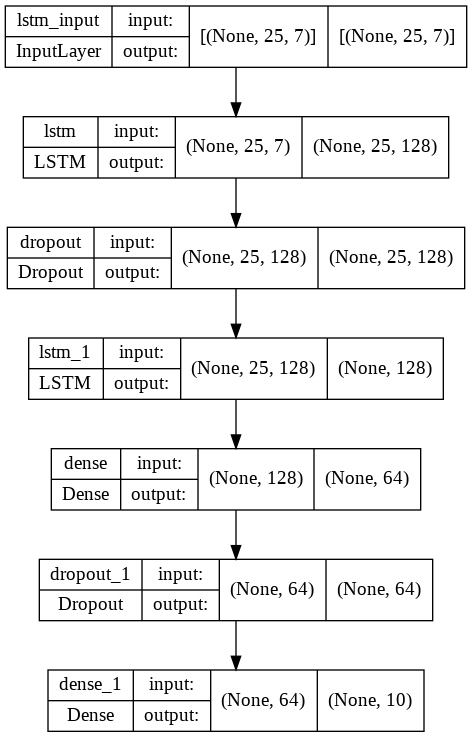

In [21]:
model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

plot_model(model, show_shapes=True, to_file='ShadowModel1.png')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 128)           69632     
                                                                 
 dropout (Dropout)           (None, 25, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 210,122
Trainable params: 210,122
Non-trai

## Training

In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'] )

model.fit(X_train, y_train, epochs=50, callbacks = [tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
1814/1814 [==============================] - 40s 18ms/step - loss: 1.1069 - accuracy: 0.6481
Epoch 2/50
1814/1814 [==============================] - 32s 18ms/step - loss: 0.8685 - accuracy: 0.7169
Epoch 3/50
1814/1814 [==============================] - 33s 18ms/step - loss: 0.7325 - accuracy: 0.7611
Epoch 4/50
1814/1814 [==============================] - 33s 18ms/step - loss: 0.6566 - accuracy: 0.7835
Epoch 5/50
1814/1814 [==============================] - 34s 19ms/step - loss: 0.6013 - accuracy: 0.7977
Epoch 6/50
1814/1814 [==============================] - 33s 18ms/step - loss: 0.5516 - accuracy: 0.8124
Epoch 7/50
1814/1814 [==============================] - 34s 19ms/step - loss: 0.5233 - accuracy: 0.8200
Epoch 8/50
1814/1814 [==============================] - 34s 19ms/step - loss: 0.4847 - accuracy: 0.8330
Epoch 9/50
1814/1814 [==============================] - 34s 18ms/step - loss: 0.4521 - accuracy: 0.8428
Epoch 10/50
1814/1814 [==============================] - 33s 18m

In [24]:
model = tf.keras.models.load_model(os.path.join(SAVED_MODEL,"ShadowModel1.h5"))

In [25]:
model.save(os.path.join(SAVED_MODEL, "ShadowModel1.h5"))

In [26]:
!tensorboard dev upload --logdir $log_dir. \
  --name "ShadowModel1" \
  --description "{win=25,shift=None,opt=Adam,loss=SCE}encoder:LSTM(128,relu)" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

.

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=AEX7zkVJdo4yepJ0pHSpPAxf3OL8W9&prompt=consent&access_type=offline
Enter the a

## Evaluation

In [27]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print('\nTrain accuracy:', train_acc)

1814/1814 [==============================] - 16s 8ms/step - loss: 0.6284 - accuracy: 0.8609

Train accuracy: 0.8609139323234558


In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

603/603 [==============================] - 5s 8ms/step - loss: 0.7543 - accuracy: 0.8171

Test accuracy: 0.8171396255493164


# 

In [29]:
y_test_pred = model.predict(X_test).argmax(axis=1)

# Confusion Matrix

Text(0.5, 1.0, 'Refined Confusion Matrix')

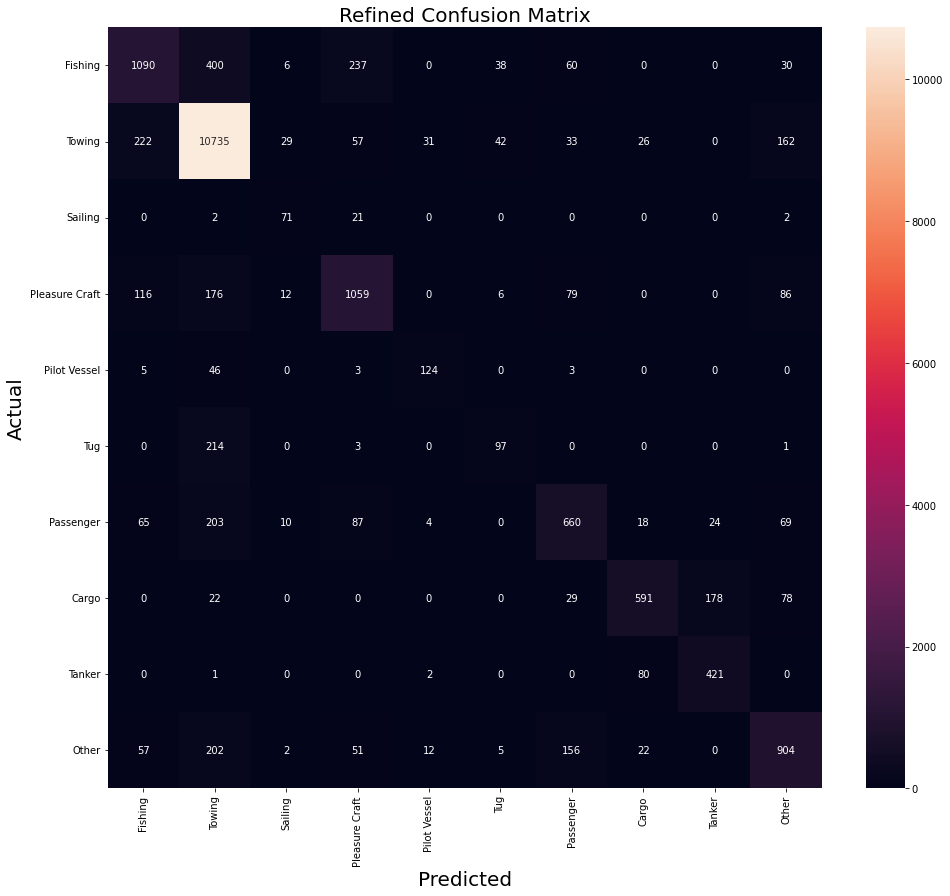

In [30]:
cf_matrix = confusion_matrix(y_test, y_test_pred)

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
class_names = ['Fishing', 'Towing', 'Sailing', 'Pleasure Craft', 'Pilot Vessel', 'Tug', 'Passenger', 'Cargo', 'Tanker', 'Other']

fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax, fmt = 'g');

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

# Black-box Behavior

In [31]:
IN_prediction = pd.DataFrame(model.predict(X_train))
IN_class = pd.DataFrame(y_train)
IN_label = pd.DataFrame(np.full(y_train.shape, 1))

OUT_prediction = pd.DataFrame(model.predict(X_test))
OUT_class = pd.DataFrame(y_test)
OUT_label = pd.DataFrame(np.full(y_test.shape, 0))

In [32]:
IN_prediction.insert(10, 'Class', IN_class)
IN_prediction.insert(11, 'Label', IN_label)
IN = IN_prediction

OUT_prediction.insert(10, 'Class', OUT_class)
OUT_prediction.insert(11, 'Label', OUT_label)
OUT = OUT_prediction

In [33]:
IN.to_csv("IN_ShadowModel1.csv", index=False)
OUT.to_csv("OUT_ShadowModel1.csv", index=False)